In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
from helpers import Reconstruct, Viz_Y,SMR,get_mixed_signal,SDR
import seaborn as sns
import warnings
import torch
import math
from tqdm import tqdm
import librosa
warnings.simplefilter('ignore')

# 1.Read speech and music data:

In [2]:
N_minutes = 3*60*44100
samplerate_s, data_speech = read("../../DATA/vocal_11.wav")
speech=data_speech[44100*10:N_minutes,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {}'.format(speech.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_s))

samplerate_m, data_music = read("../../DATA/piano_10.wav")
music=data_music[44100*10:N_minutes,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_m))


Shape of the speech 7497000
Length : 170.00s
Sample rate : 44100
Shape of the music 7497000
Length : 170.00s
Sample rate : 44100


# Get test data:

## Apply STFT :

### We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size

In [11]:
test,speech,music=get_mixed_signal(speech,music,10)

WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.4 * WINDOW_SIZE
NFFT=512

f,t,Y_s= signal.stft(speech,samplerate_s,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_s=np.abs(Y_s)

f,t,Y_m= signal.stft(music,samplerate_m,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_m=np.abs(Y_m)

print('Shape of spectrogram speech : {}'.format(Yabs_s.shape))
print('Shape of spectrogram music: {}'.format(Yabs_m.shape))

SMR = 10.00
Shape of spectrogram speech : (513, 11486)
Shape of spectrogram music: (513, 11486)


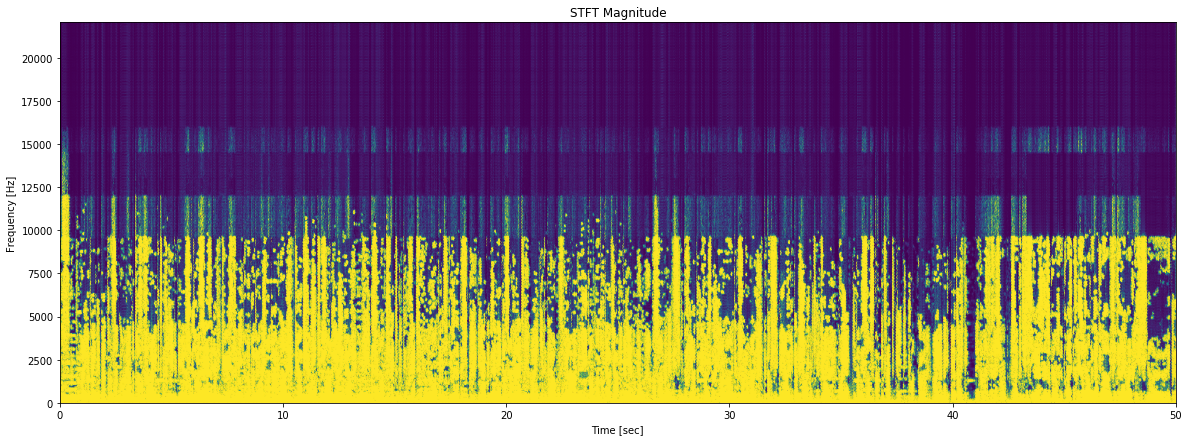

In [13]:
Viz_Y(t,f,Yabs_s)

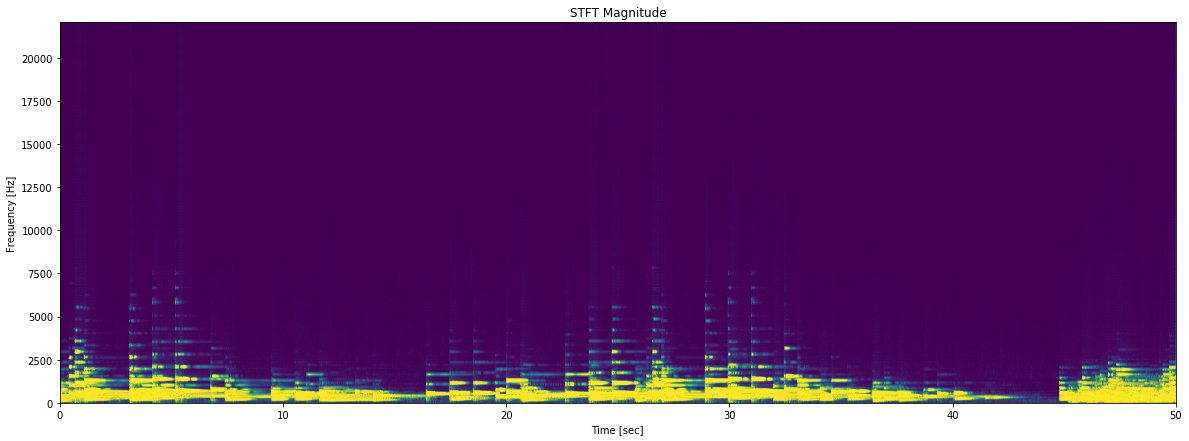

In [12]:
Viz_Y(t,f,Yabs_m)

# Tuning Loop :

In [8]:
def Evaluation(speech, music,Ns,Nm,SMR_db,samplerate,p):
    
    
    test,speech_test,music_test=get_mixed_signal(speech,music,SMR_db)
    test=test[882000:3*882000]
    speech_test=speech_test[882000:3*882000]
    music_test = music_test[882000:3*882000]
    
    WINDOW = 'hamming'
    WINDOW_SIZE=480
    OVERLAP = 0.6 * WINDOW_SIZE
    NFFT=512

    f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_s=np.abs(Y)

    f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_m=np.abs(Y)

    f,t,Y= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_t=np.abs(Y)
    
    Yabs_s[Yabs_s==0]=0.0001
    Yabs_t[Yabs_t==0]=0.0001
    Yabs_m[Yabs_m==0]=0.0001

    model = NMF(n_components=Ns, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
    G_s = model.fit_transform(np.transpose(Yabs_s))
    B_s = model.components_
    
    
    model = NMF(n_components=Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
    G_m = model.fit_transform(np.transpose(Yabs_m))
    B_m = model.components_

    B=np.vstack([B_s,B_m])
    
    
    model_test = NMF(n_components=Ns+Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
    model_test.fit(np.transpose(Yabs_t))
    
    model_test.components_=B
    G_test=model_test.transform(np.transpose(Yabs_t))
    
    
    Sources,Masks=Reconstruct(B=np.transpose(B),G=np.transpose(G_test),Ns=Ns,Nm=Nm,Yabs=Y,p=p)
    
    speech_est = Sources[0]
    music_est = Sources[1]
    
    _, speech_est =  signal.istft(speech_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    _, music_est =  signal.istft(music_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    speech_est = speech_est[:speech_test.shape[0]]
    music_est = music_est[:music_test.shape[0]]
    
    sdr_speech = SDR(s_est=speech_est,s=speech_test)
    sdr_music = SDR(s_est=music_est, s=music_test)
    
    return sdr_speech, sdr_music
    

In [ ]:
SDR_MUSIC=[]
SDR_SPEECH=[]

for SMR in tqdm([-5,5]):
    
    SDR_MUSIC_Ncomp=[]
    SDR_SPEECH_Ncomp=[]
    
    for Ns in tqdm([2,32,64,128]):
            
            SDR_MUSIC_P=[]
            SDR_SPEECH_P=[]

            for p in [3]:
                
                print('Evaluation SMR = {} Ns = Nm = {} p = {}'.format(SMR,Ns,p))
                sdr_speech,sdr_music=Evaluation(speech=speech, music=music,Ns=Ns,Nm=Ns,SMR_db=SMR,samplerate=samplerate_s,p=p)
                SDR_SPEECH_P.append(sdr_speech)
                SDR_MUSIC_P.append(sdr_music)
                print('Speech SDR = {} ... Music SDR = {}'.format(sdr_speech,sdr_music))

            SDR_MUSIC_Ncomp.append(SDR_MUSIC_P)
            SDR_SPEECH_Ncomp.append(SDR_SPEECH_P)
            
    SDR_MUSIC.append(SDR_MUSIC_Ncomp)
    SDR_SPEECH.append(SDR_SPEECH_Ncomp)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Evaluation SMR = -5 Ns = Nm = 2 p = 3
SMR = -5.00



 25%|████████████████████▊                                                              | 1/4 [05:30<16:31, 330.36s/it]

Speech SDR = 1.2541684098360895 ... Music SDR = 2.0229307018354623
Evaluation SMR = -5 Ns = Nm = 32 p = 3
SMR = -5.00



 50%|█████████████████████████████████████████▌                                         | 2/4 [25:20<19:36, 588.22s/it]

Speech SDR = 1.5734312028604434 ... Music SDR = 2.3421934948598153
Evaluation SMR = -5 Ns = Nm = 64 p = 3
SMR = -5.00


In [ ]:
SDR_MUSIC_ARRAY=np.array(SDR_MUSIC)
SDR_SPEECH_ARRAY=np.array(SDR_SPEECH)
np.save('./SDR/Music_sdr2',SDR_MUSIC_ARRAY)
np.save('./SDR/Speech_sdr2',SDR_SPEECH_ARRAY)

# Test on one configuration :

In [3]:
samplerate_t=samplerate_m

In [26]:
def Test(speech, music,Ns,Nm,SMR_db,samplerate,p):
    
    # Set the test data:
    test,speech_test,music_test=get_mixed_signal(speech,music,SMR_db)
    test=test[5*882000:6*882000]
    speech_test=speech_test[5*882000:6*882000]
    music_test = music_test[5*882000:6*882000]
    
    #write("../../Tests/Test.wav", samplerate_t, test.astype(np.int16))
    
    WINDOW = 'hamming'
    WINDOW_SIZE=256
    OVERLAP = 0.6 * WINDOW_SIZE
    NFFT=1024

    f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_s=np.abs(Y)

    f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_m=np.abs(Y)

    f,t,Y= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_t=np.abs(Y)
    
    Yabs_s[Yabs_s==0]=0.0001
    Yabs_t[Yabs_t==0]=0.0001
    Yabs_m[Yabs_m==0]=0.0001

    model = NMF(n_components=Ns, init='random',alpha=0.2,beta_loss='itakura-saito',solver="mu",max_iter=300, random_state=0)
    G_s = model.fit_transform(np.transpose(Yabs_s))
    B_s = model.components_
    
    print('Train NMF 1 ... Done')
    
    model = NMF(n_components=Nm, init='random',alpha=0.2,beta_loss='itakura-saito',solver="mu",max_iter=300, random_state=0)
    G_m = model.fit_transform(np.transpose(Yabs_m))
    B_m = model.components_

    print('Train NMF 2 ... Done')

    B=np.vstack([B_s,B_m])
    
    
    model_test = NMF(n_components=Ns+Nm, init='random',alpha=0.2,beta_loss='itakura-saito',solver="mu",max_iter=300, random_state=0)
    model_test.fit(np.transpose(Yabs_t))
    
    model_test.components_=B
    G_test=model_test.transform(np.transpose(Yabs_t))
    
    
    Sources,Masks=Reconstruct(B=np.transpose(B),G=np.transpose(G_test),Ns=Ns,Nm=Nm,Yabs=Y,p=p)
    
    speech_est = Sources[0]
    music_est = Sources[1]
    
    _, speech_est =  signal.istft(speech_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    _, music_est =  signal.istft(music_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    speech_est = speech_est[:speech_test.shape[0]]
    music_est = music_est[:music_test.shape[0]]
    
    sdr_speech = SDR(s_est=speech_est,s=speech_test)
    sdr_music = SDR(s_est=music_est, s=music_test)
    
    print('SDR Speech = {:.2f} ... SDR Music = {:.2f}'.format(sdr_speech,sdr_music))
    
    write("../../Tests/SpeechX.wav", samplerate_t, speech_est.astype(np.int16))
    write("../../Tests/MusicX.wav", samplerate_t, music_est.astype(np.int16))

In [ ]:
Test(speech=speech, music=music,Ns=256,Nm=8,SMR_db=0,samplerate=samplerate_m,p=3)

Train NMF 1 ... Done


# Devide high and low frequencies:

In [80]:
def Test(speech, music,Ns,Nm,SMR_db,samplerate,p):
    
    # Set test data:
    test,speech_test,music_test=get_mixed_signal(speech,music,SMR_db)
    test=test[4*882000:6*882000]
    speech_test=speech_test[4*882000:6*882000]
    music_test = music_test[4*882000:6*882000]
    
    write("../../Tests/Test.wav", samplerate_t, test.astype(np.int16))
    
    
    
    """
    Compute the STFT
    """
    WINDOW = 'hamming'
    WINDOW_SIZE=128
    OVERLAP = 0.4 * WINDOW_SIZE
    NFFT=512

    f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_s=np.abs(Y)

    f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_m=np.abs(Y)

    f,t,Y= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
    Yabs_t=np.abs(Y)
    
    Yabs_s[Yabs_s==0]=0.0001
    Yabs_t[Yabs_t==0]=0.0001
    Yabs_m[Yabs_m==0]=0.0001

    
    
    size=f[f<2500].shape[0]

    
    """
    Devide the STFT into high and low frequencies
    """
    
    Y1=Y[:size,:]
    Y2=Y[size:,:]
    Yabs_s1=Yabs_s[:size,:]
    Yabs_s2=Yabs_s[size:,:]
    
    Yabs_m1=Yabs_m[:size,:]
    Yabs_m2=Yabs_m[size:,:]  
    
    Yabs_t1=Yabs_t[:size,:]
    Yabs_t2=Yabs_t[size:,:]  
    
    
       
    """
    Apply NMF On low frequencies :
    """
    model = NMF(n_components=Ns, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    G_s = model.fit_transform(np.transpose(Yabs_s1))
    B_s = model.components_
    
    print('Train NMF 1*1 ... Done')
    
    model = NMF(n_components=Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    G_m = model.fit_transform(np.transpose(Yabs_m1))
    B_m = model.components_

    print('Train NMF 2*1 ... Done')

    B=np.vstack([B_s,B_m])
    
    
    model_test = NMF(n_components=Ns+Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    model_test.fit(np.transpose(Yabs_t1))
    
    model_test.components_=B
    G_test=model_test.transform(np.transpose(Yabs_t1))
    
    
    Sources,Masks=Reconstruct(B=np.transpose(B),G=np.transpose(G_test),Ns=Ns,Nm=Nm,Yabs=Y1,p=p)
    
    speech_est1 = Sources[0]
    music_est1 = Sources[1]
    
    
    """
    Apply NMF on high frequencies :
    """
    model = NMF(n_components=Ns, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    G_s = model.fit_transform(np.transpose(Yabs_s2))
    B_s = model.components_
    
    print('Train NMF 1*2 ... Done')
    
    model = NMF(n_components=Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    G_m = model.fit_transform(np.transpose(Yabs_m2))
    B_m = model.components_

    print('Train NMF 2*2 ... Done')

    B=np.vstack([B_s,B_m])
    
    
    model_test = NMF(n_components=Ns+Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    model_test.fit(np.transpose(Yabs_t2))
    
    model_test.components_=B
    G_test=model_test.transform(np.transpose(Yabs_t2))
    
    
    Sources,Masks=Reconstruct(B=np.transpose(B),G=np.transpose(G_test),Ns=Ns,Nm=Nm,Yabs=Y2,p=p)
    
    speech_est2 = Sources[0]
    music_est2 = Sources[1]
      
    
    """
    Concat the results
    """
    speech_est = np.vstack([speech_est1,speech_est2])
    music_est=np.vstack([music_est1,music_est2])
    
    
    
    """
    Reconstruct the signal
    """
    
    _, speech_est =  signal.istft(speech_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    _, music_est =  signal.istft(music_est,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
    
    speech_est = speech_est[:speech_test.shape[0]]
    music_est = music_est[:music_test.shape[0]]
    
    sdr_speech = SDR(s_est=speech_est,s=speech_test)
    sdr_music = SDR(s_est=music_est, s=music_test)
    
    print('SDR Speech = {:.2f} ... SDR Music = {:.2f}'.format(sdr_speech,sdr_music))
    
    write("../../Tests/Speech1.wav", samplerate_t, speech_est.astype(np.int16))
    write("../../Tests/Music1.wav", samplerate_t, music_est.astype(np.int16))

In [81]:
Test(speech=speech, music=music,Ns=128,Nm=128,SMR_db=0,samplerate=samplerate_m,p=3)

Train NMF 1*1 ... Done
Train NMF 2*1 ... Done
Train NMF 1*2 ... Done
Train NMF 2*2 ... Done
SDR Speech = 5.44 ... SDR Music = -0.31
